In [18]:
import sys
sys.path.append('../src')
import P_binary
import P_random
import P_posterior
import const as c
import time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from numpy.random import normal

%matplotlib inline

### Load NLTT Catalog

In [2]:
# Read in sample from Tycho-2 table
filename = ('../data/rNLTT/catalog_tabs.dat')
t_full = Table.read(filename, format='ascii', guess=True)

# Change proper motion units from asec/yr to mas/yr
t_full['mu_ra'] = 1.0e3*t_full['mu_ra']
t_full['mu_dec'] = 1.0e3*t_full['mu_dec']
t_full['mu_ra_err'] = 1.0e3*t_full['mu_ra_err']
t_full['mu_dec_err'] = 1.0e3*t_full['mu_dec_err']

# Select only stars with proper motion uncertainties greater than 1 mas/yr - remove junk
ids_good = np.union1d( np.where(t_full['mu_ra_err'] > 1.0)[0], \
                      np.where(t_full['mu_dec_err'] > 1.0)[0] )
t = t_full[ids_good]

### Load Chaname & Gould (2004) catalog

In [3]:
# Read in pairs identified by Chaname & Gould

filename_CG = ('../data/rNLTT/Chaname_Gould_pairs.dat')
CG_pairs = Table.read(filename_CG, format='cds')
CG_pairs = CG_pairs[0:-1]  # Because the last line is blank

### Let's pick one pair and test

In [63]:
id1 = 1012.
id2 = 1018.

i = np.argmin(np.abs(id1 - t['NLTT']))
j = np.argmin(np.abs(id2 - t['NLTT']))

star1 = t['ra'][i], t['dec'][i], t['mu_ra'][i], t['mu_dec'][i], \
        t['mu_ra_err'][i], t['mu_dec_err'][i]
star2 = t['ra'][j], t['dec'][j], t['mu_ra'][j], t['mu_dec'][j], \
        t['mu_ra_err'][j], t['mu_dec_err'][j]

In [66]:
pos_density = P_random.get_sigma_pos(star1[0], star1[1], catalog=t, method='kde')
pm_density = P_random.get_sigma_mu(star1[2], star1[3], catalog=t, method='kde')

delta_pm_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
delta_pm_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)


prob_post = np.array([])
prob_pos = np.array([])
prob_mu = np.array([])
num_samples = 10**np.linspace(1, 5, 25)
for n in num_samples:

    P_post, P_pos, P_mu = P_random.get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                    star1[2], star1[3], star2[2], star2[3],
                                    delta_mu_ra_err=delta_pm_ra_err, delta_mu_dec_err=delta_pm_dec_err,
                                    pos_density=pos_density, pm_density=pm_density,
                                    nsamples=n, catalog=t)
    
    
    prob_post = np.append(prob_post, P_post)
    prob_pos = np.append(prob_pos, P_pos)
    prob_mu = np.append(prob_mu, P_mu)

    


In [17]:
P_binary.generate_binary_set(num_sys=100000, dist=100.0)

In [69]:
theta = P_random.get_theta_proj_degree(t['ra'][i], t['dec'][i], t['ra'][j], t['dec'][j])


prob_bin = np.array([])
num_samples = 10**np.linspace(1, 5, 2)
for n in num_samples:

    delta_mu_ra_sample = normal(loc=(t['mu_ra'][i] - t['mu_ra'][j]), \
                                scale=delta_pm_ra_err, \
                                size=n)
    delta_mu_dec_sample = normal(loc=(t['mu_dec'][i] - t['mu_dec'][j]), \
                                 scale=delta_pm_dec_err, \
                                 size=n)
    delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)

    # Monte Carlo integrate observational uncertainties on delta mu
    prob_tmp = P_binary.get_P_binary(theta * 3600.0, delta_mu_sample)
    prob_bin = np.append(prob_bin, 1.0/n * np.sum(prob_tmp))
    

/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


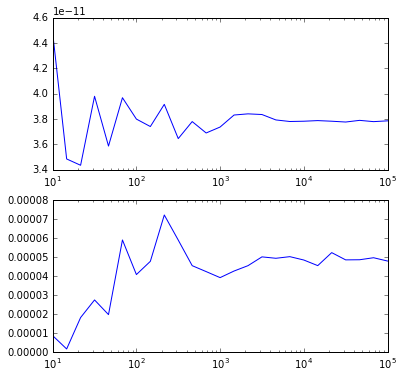

In [67]:
fig, ax = plt.subplots(2,1, figsize=(6,6))


ax[0].plot(num_samples, prob_post)
ax[1].plot(num_samples, prob_bin)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
    
plt.show()